In [61]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import random

import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
import warnings
import pickle
warnings.filterwarnings("ignore")



In [62]:
path_to_data = os.path.join('data', 'nn_data')
stations = os.listdir(path_to_data)
random.shuffle(stations)
partition = {"train_share": 0.5, "val_share": 0.25, "test_share":  0.25}
train_len = int(len(stations) * partition["train_share"])
val_len = int(len(stations) * partition["val_share"])
test_len = int(len(stations) * partition["test_share"])
train_sts, val_sts, test_sts = stations[:train_len], stations[train_len:train_len+val_len], stations[train_len+val_len:]
st_split_dict = {"Train": train_sts, "Val": val_sts, "Test": test_sts}
# print("Train stations: ", train_sts)
# print("Val stations: ", val_sts)
# print("Test stations: ", test_sts)
print(st_split_dict)

{'Train': ['Туапсе', 'Приморско-Ахтарск'], 'Val': ['Краснодар, Круглик'], 'Test': ['Анапа']}


In [66]:
path_to_dump = os.path.join('data','nn_data')
X = {}
y = {}
for split_part, sts in st_split_dict.items():
    X_split = []
    y_split = []
    for st in sts:
        st_dir = os.path.join(path_to_dump, st)
        with open(os.path.join(st_dir, 'objects.pkl'),'rb') as f:
            X_ = pickle.load(f)
        with open(os.path.join(st_dir, 'target.pkl'),'rb') as f:
            y_ = pickle.load(f)
        X_split.append(X_)
        y_split.append(y_)
    X[split_part] = np.concatenate(X_split)
    y[split_part] = np.concatenate(y_split)


In [30]:
X_tensor = torch.tensor(X).cuda()
y_tensor = torch.tensor(y).cuda()

#normalize data
mean_channels = X_tensor.mean(dim=[0, -1, -2])
std_channels = X_tensor.std(dim=[0, -1, -2])
preprocess = T.Compose([
   T.Normalize(
       mean=mean_channels,
       std=std_channels
   )
])
X_tensor = preprocess(X_tensor)

#assemble into datadet and dataloader
dataset = TensorDataset(X_tensor,y_tensor)
dataloader = DataLoader(dataset)

In [51]:
tmp=torch.unique(dataset.tensors[-1]).cpu().numpy()
tmp

array([False,  True])

Text(0.5, 1.0, 'Entire Dataset (before train/val/test split)')

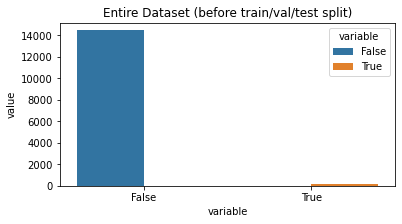

In [62]:
def get_class_distribution(dataset_obj):
    count_dict = {k:0 for k in torch.unique(dataset_obj.tensors[-1]).cpu().numpy()}
    for _, label_id in dataset_obj:
        label = label_id
        count_dict[np.bool(label.cpu().numpy())] += 1
    return count_dict
def plot_from_dict(dict_obj, plot_title, **kwargs):
    return sns.barplot(data = pd.DataFrame.from_dict([dict_obj]).melt(), x = "variable", y="value", hue="variable", **kwargs).set_title(plot_title)
plt.figure(figsize=(6,3))
plot_from_dict(get_class_distribution(dataset), plot_title="Entire Dataset (before train/val/test split)")

In [ ]:
dataset_size = len(dataset)
dataset_indices = list(range(dataset_size))
np.random.shuffle(dataset_indices)
 X_train, X_test, y_train, y_test 
    = train_test_split(X, y, test_size=0.2, random_state=1)

 X_train, X_val, y_train, y_val 
    = train_test_split(X_train, y_train, test_size=0.25, random_state=1)